# Boltzmann-Gibbs Wealth Model

In 2002, Dragulescu, A and Yakovenko, V published [a short paper](https://arxiv.org/pdf/cond-mat/0211175v1) applying the Boltzmann–Gibbs law from statistical mechanics to a closed economic system. The simplest version of this model operates under a few rules: 

1. The model consists of a fixed number of agents and a fixed amount of wealth. No wealth is created or destroyed.
2. The model starts with an equal distribution of wealth among the agents.
3. At each step of the model, agents exchange a small, fixed amount of wealth.

When this simulation is run for many steps, the initial state of perfect equality quickly disappears. The distribution of wealth among the agents settles into a stable, highly unequal pattern that closely follows an exponential distribution (the Boltzmann-Gibbs distribution). A high number of agents will have no wealth and a small number of agents will end up with a large portion of wealth.

## Notebook Goals

- Create a simple model of this closed, economic system.
- Visualize the results with two charts:
    - Heatmap of wealth accumulation on a 2D grid.
    - Distribution of wealth among agents.

In [50]:
from mesa.model import Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.nvx_sim.economy.agents import WealthAgent

## Notebook Variables

I like watching data change over time. Generating a chart for each step of the simulation can be a time-consuming operation, especially if you crank up the simulation steps. The variables are here to toggle off the GIF generation.

In [51]:
# Should the notebook generate a GIF showing the heatmap of total wealth in each cell of the grid for each step of the simulation?
SHOULD_CREATE_HEATMAP_GIF = False

# Should the notebook generate a GIF showing the wealth distribution chart for each step of the simulation?
SHOULD_CREATE_WEALTH_DISTRIBUTION_GIF = False

## Custom Agent

Subclass the generic `WealthAgent` from the `nvx_sim.economy` module and allow controlling the rate at which the agent gives away their wealth. 

In [52]:
class SimpleWealthAgent(WealthAgent):
    """
    A simple agent which gives their money away to nearby agents at a defined rate.
    
    Attributes:
        wealth (int): The agent's current wealth.
        give_wealth_chance (float): Chance for the agent to give their wealth away.
    """
    def __init__(self, model, initial_wealth = 1, give_wealth_chance = 0.5, **kwargs):
        super().__init__(model, initial_wealth, enable_debt=False)
        self.give_wealth_chance = give_wealth_chance
    
    def step(self):
        self.move()
        all_agents_in_cell = self.model.grid.get_cell_list_contents([self.pos])
        
        if len(all_agents_in_cell) > 1 and self.wealth > 0 and self.random.random() <= self.give_wealth_chance:
            target = self.random.choice([a for a in all_agents_in_cell if a != self])
            self.give_wealth(1, target)

In [53]:
class BoltzmannWealthModel(Model):
    """
    A simple economic model where agents exchange currency at random.
    """
    
    def __init__(self, num_agents=100, width=15, height=15, agent_wealth_classes=None, seed=None):
        super().__init__(seed=seed)
        
        self.grid = MultiGrid(width, height, torus=True)
        self.num_agents = num_agents
        
        self.datacollector = DataCollector(
            agent_reporters={"wealth": "wealth"},
            model_reporters={"grid_state": self.get_wealth_grid} ,
        )
        
        agents = []
        if agent_wealth_classes is None:
            for _ in range(self.num_agents):
                agents.append(SimpleWealthAgent(self))
        else:
            for wealth_class, config in agent_wealth_classes.items():
                for _ in range(int(self.num_agents * config["rate"])):
                    agents.append(SimpleWealthAgent(self, **config))
                
        for agent in agents:
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))
        
        self.datacollector.collect(self)
        
    def get_wealth_grid(self):
        """
        Creates a 2D numpy array representing the total wealth of each grid cell. 
        """
        wealth_grid = np.zeros((self.grid.width, self.grid.height))
        
        for cell in self.grid.coord_iter():
            agents, (x, y) = cell
            if agents:
                wealth_grid[x][y] = sum([a.wealth for a in agents])
            else:
                wealth_grid[x][y] = 0
                
        return wealth_grid
        
    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)

## The Simulation

In [62]:
# Simulation Variables
NUM_AGENTS = 100
GRID_WIDTH = 15
GRID_HEIGHT = 15
NUM_STEPS = 20
SEED = 651685
AGENT_WEALTH_CLASSES = {
    # "upper_class": {"rate": 0.05, "initial_wealth": 10, "give_wealth_chance": 0.5},
    # "middle_class": {"rate": 0.30, "initial_wealth": 3, "give_wealth_chance": 0.8},
    # "lower_class": {"rate": 0.65, "initial_wealth": 1, "give_wealth_chance": 0.5},
    "uniform_class": {"rate": 1.0, "initial_wealth": 1, "give_wealth_chance": 0.5},
}

model = BoltzmannWealthModel(NUM_AGENTS, GRID_WIDTH, GRID_HEIGHT, AGENT_WEALTH_CLASSES, SEED)
for i in range(NUM_STEPS):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

### Heatmap of Wealth Accumulation

Each cell on the grid has some number of agents with some amount of wealth. This heatmap shows the total amount of wealth for each cell at the start of the simulation.

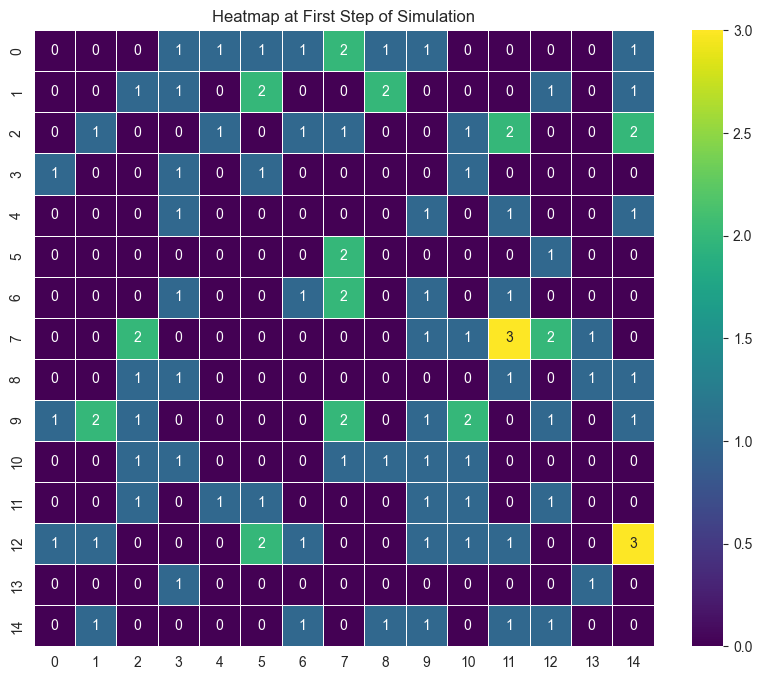

In [63]:
grid_state_data = model_data.iloc[0]["grid_state"]
plt.figure(figsize=(10, 8))
ax = sns.heatmap(grid_state_data, cmap="viridis", linewidths=.5, annot=True)
ax.set_title(f"Heatmap at First Step of Simulation")
plt.show()
plt.close()

And this heatmap shows the total amount of wealth for each cell at the end of the simulation. See how pockets of wealth are beginning to accumulate?

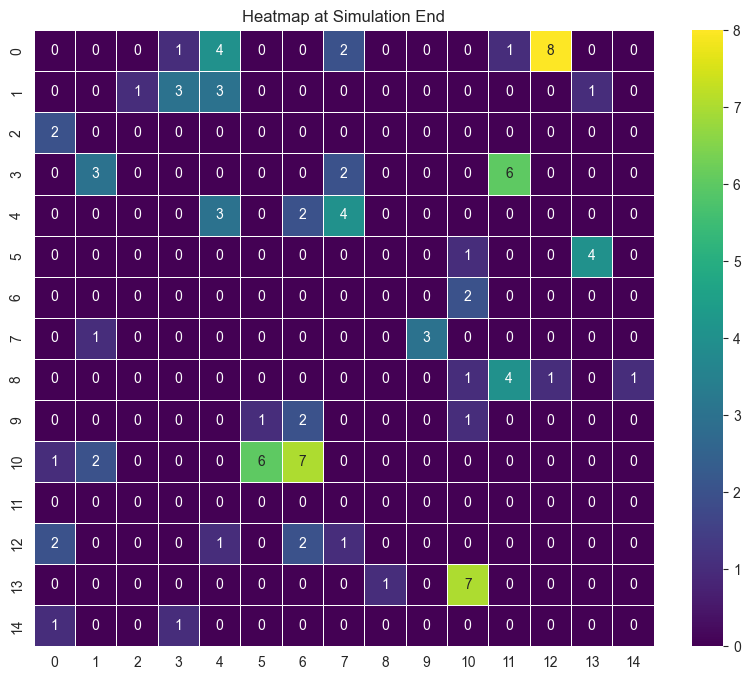

In [64]:
grid_state_data = model_data.iloc[NUM_STEPS]["grid_state"]
plt.figure(figsize=(10, 8))
ax = sns.heatmap(grid_state_data, cmap="viridis", linewidths=.5, annot=True)
ax.set_title(f"Heatmap at Simulation End")
plt.show()
plt.close()

### Animated Heatmap of Wealth Accumulation

As I said, GIFs help me learn. Although if I'm being honest, this one is difficult to follow.

In [57]:
if SHOULD_CREATE_HEATMAP_GIF:
    import io, imageio
    with imageio.get_writer("e01_heatmap.gif", mode="I", fps=(NUM_STEPS // 5)) as writer:
        for step, row in model_data.iterrows():
            grid_state_data = row["grid_state"]
            plt.figure()
            ax = sns.heatmap(grid_state_data, cmap="viridis", linewidths=.5)
            ax.set_title(f"Heatmap at Step {step}")
            buffer = io.BytesIO()
            plt.savefig(buffer, format="png")
            buffer.seek(0)
            im = imageio.v2.imread(buffer, format="png")
            writer.append_data(im)
            plt.close()

![Animated Heatmap](e01_heatmap.gif)

## Chart of Wealth Distribution

This is the more fascinating result from this model, at least for me. By the end of the simulation, most of the agents have no wealth, some will have the amount they started with, and a few will hold large amounts of wealth. This rule holds true at 20 simulation steps or 100,000 simulation steps.

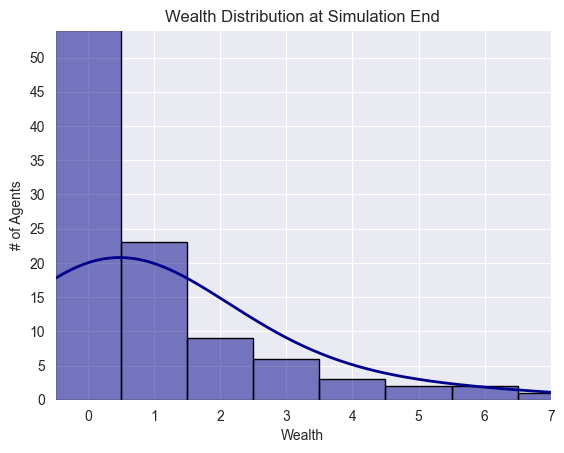

In [65]:
agent_data_last_step = agent_data[agent_data.index.get_level_values('Step').isin([NUM_STEPS])]
df = agent_data_last_step.reset_index(level=['AgentID'])
df = df.groupby("wealth").size()
x = df.index.tolist()
y = df.values.tolist()
plt.figure()
sns.histplot(x=x, weights=y, discrete=True,
             color='darkblue', edgecolor='black',
             kde=True, kde_kws={'cut': 2}, line_kws={'linewidth': 2})
plt.xlim(-0.5, max(x))
plt.xticks(range(0, max(x) + 1, max((max(x) // 10), 1)))
plt.xlabel("Wealth")
plt.ylim(0, max(y))
plt.yticks(range(0, max(y)+1, max((max(y) // 10), 1)))
plt.ylabel("# of Agents")
plt.title("Wealth Distribution at Simulation End")

plt.show()
plt.close()

In [59]:
if SHOULD_CREATE_WEALTH_DISTRIBUTION_GIF:
    import io, imageio
    with imageio.get_writer("e01_wealth_distribution.gif", mode="I", fps=(NUM_STEPS // 5)) as writer:
        for step in agent_data.index.get_level_values('Step').unique():
            if step == 0: continue
            df = agent_data[agent_data.index.get_level_values('Step').isin([step])]
            df = df.reset_index(level=['AgentID'])
            df = df.groupby("wealth").size()
            x = df.index.tolist()
            y = df.values.tolist()
            plt.figure()
            sns.histplot(x=x, weights=y, discrete=True,
                 color='darkblue', edgecolor='black',
                 kde=True, kde_kws={'cut': 2}, line_kws={'linewidth': 2})
            plt.xlim(-0.5, 12)
            plt.xticks(range(0, 12+1, 2))
            plt.xlabel("Wealth")
            plt.ylim(0, NUM_AGENTS)
            plt.yticks(range(0, NUM_AGENTS+1, (NUM_AGENTS // 10)))
            plt.ylabel("# of Agents")
            plt.title(f"Wealth Distribution at Step {step}")
            buffer = io.BytesIO()
            plt.savefig(buffer, format="png")
            buffer.seek(0)
            plt.close()
            writer.append_data(im)

![Animated Density Graph](e01_density.gif)